In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import utils

%matplotlib inline

Using TensorFlow backend.


# Load up the decoder models

In [2]:
decoder_folder = 'Models' # This folder contains the decoder NN models.
output_folder = 'Text' # Model output will be serialized to this subfolder.

# The upsampling of the raw data introduced artifacts in their spectra; downsampling can partially mitigate this.
high_ds = [6, 7, 8, 9, 10] # Process these datasets at 100 Hz (their upsampled resolution)
factors = [7, 7, 7, 7, 7, 2, 2, 2, 7, 4] # Estimate noise on decimated data (at approx. their native frame rate)
covariates = True # Pass estimates of decay + noise into decoder?

In [3]:
# Load the models to evaluate
models = []
names = os.listdir(decoder_folder)
[names.remove(name) for name in names if name[0] == '.']
ar = []
for x in names:
    if x[0] is not '.':
        models.append(keras.models.load_model(decoder_folder + '/' + x))
        
        # Get the AR model type (1 or 2) from the filename
        ar.append(int(x.split('-')[utils.AR_IDX+1][0]))

In [6]:
models[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 100)         320100    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 100)         320100    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
__________

In [4]:
# Set the figure style
sns.set_style("whitegrid", {'axes.grid' : True})

# Process all of the datasets with all of the decoder models

In [5]:
results = [] # Store all the summary dataframes
spikes_all = [] # Store all the CSV files from all the training data
spikes_all_test = [] # Store all the CSV files from all the test data

# Evaluate all datasets
for ds in range(1,11):
    print('Evaluating ', str(ds))
    F, s = utils.load_evaluation_data(ds)
    high_resolution = True if ds in high_ds else False
    
    # If we're on dataset 5, convolve with a gaussian (we optimized these parameters elsewhere):
    if ds == 5:
        kernel_scale=7
        kernel_size=13
    else:
        kernel_scale = None
        kernel_size = None
        
    # Evaluate each dataset
    result, spikes = utils.evaluate_dataset(F, s, np.array(models), np.array(names), factor=factors[ds-1],
                                            p=ar, high_resolution=high_resolution, kernel_scale=kernel_scale,
                                            kernel_size=kernel_size, covariates=covariates, dataset=ds)
    results.append(result)
    spikes_all.append(spikes)
    
    # Test data is only available for 
    if ds < 6:
        Ft, st = utils.load_evaluation_data(ds, train=False)
        _, spikes_test = utils.evaluate_dataset(Ft, st, np.array(models), np.array(names), factor=factors[ds-1],
                                                p=ar, high_resolution=high_resolution, kernel_scale=kernel_scale,
                                                kernel_size=kernel_size, covariates=covariates,
                                                dataset=ds, train=False)
        spikes_all_test.append(spikes_test)
    
results_all = pd.concat(results)

Evaluating  1
Evaluating  2
Evaluating  3
Evaluating  4
Evaluating  5


/usr/local/lib/python3.4/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 61, using nperseg = 61
  .format(nperseg, input_length))
/usr/local/lib/python3.4/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 90, using nperseg = 90
  .format(nperseg, input_length))


Evaluating  6
Evaluating  7
Evaluating  8
Evaluating  9
Evaluating  10


# Look at which model was best for each dataset

10 4
1 3 OGB 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-1.hdf5
2 3 OGB 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-1.hdf5
3 2 GCaMP6S 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-True-32-0.04-2.hdf5
4 3 OGB 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-1.hdf5
5 0 GCaMP6S 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5
6 0 GCaMP5K 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5
7 0 GCaMP6F 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5
8 0 GCaMP6S 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5
9 4 jRCaMP 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-2.hdf5
10 4 jRGECO 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-2.hdf5

array([ 0.48,  0.43,  0.46,  0.43,  0.37,  0.62,  0.71,  0.58,  0.46,  0.67])

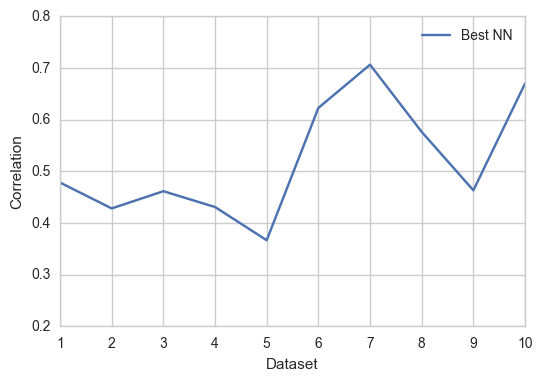

In [6]:
# Get the best model for each dataset (mean)
best_models, best_corr = utils.get_best_models(results_all, names)
np.round(best_corr,2)

In [7]:
# Get the best model for each dataset (median)
best_models, best_corr = utils.get_best_models(results_all, names, mean=False)
np.round(best_corr,2)

10 4
1 2 OGB 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-True-32-0.04-2.hdf5
2 3 OGB 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-1.hdf5
3 2 GCaMP6S 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-True-32-0.04-2.hdf5
4 3 OGB 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-1.hdf5
5 2 GCaMP6S 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-True-32-0.04-2.hdf5
6 0 GCaMP5K 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5
7 0 GCaMP6F 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5
8 0 GCaMP6S 5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5
9 4 jRCaMP 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-2.hdf5
10 3 jRGECO 5000-20-[0.0, 2.0]-[0.5, 3.0]-True-[0.906, 0.997]-1-100-[1, 2, 4, 8]-True-32-0.01-1.hdf5


array([ 0.48,  0.47,  0.5 ,  0.53,  0.4 ,  0.65,  0.74,  0.61,  0.54,  0.76])

# Serialize Results to CSV

In [8]:
# Save out all the data to CSV files
import spikefinder
for kind in ['train', 'test']:
    spikes = spikes_all if kind == 'train' else spikes_all_test
    ds_range = range(1,11) if kind == 'train' else range(1,6)
    for ds in ds_range:
        # Save out the best model's dataframe
        model_idx = names.index(best_models[ds-1])
        out_path = output_folder + '/' + str(ds) + '.' + kind + '.spikes.csv'
        
        if kind == 'train':
            train_dataframe = spikes_all[ds-1][model_idx][0]
            train_dataframe.to_csv(out_path)
        else:
            print('Test ', ds)
            test_dataframe = spikes_all_test[ds-1][model_idx][0]
            test_dataframe.to_csv(out_path)           

        # Load up the training dataset
        train = True if kind == 'train' else False
        F, s = utils.load_evaluation_data(ds, train)

        # See if the saved dataframe is correct
        if kind == 'train':
            loaded_dataframe = pd.DataFrame.from_csv(out_path)
            score = np.median(spikefinder.score(train_dataframe, s))
            assert np.abs(best_corr[ds-1] - score) < 1e-10
            print('Dataset ', ds, ' Expected:' , best_corr[ds-1], ' Got:', score)

Dataset  1  Expected: 0.4788846191  Got: 0.4788846191
Dataset  2  Expected: 0.465524575293  Got: 0.465524575293
Dataset  3  Expected: 0.495238368715  Got: 0.495238368715
Dataset  4  Expected: 0.528773853217  Got: 0.528773853217
Dataset  5  Expected: 0.39513781131  Got: 0.39513781131
Dataset  6  Expected: 0.645084274319  Got: 0.645084274319
Dataset  7  Expected: 0.740286152034  Got: 0.740286152034
Dataset  8  Expected: 0.607170229217  Got: 0.607170229217
Dataset  9  Expected: 0.541442366628  Got: 0.541442366628
Dataset  10  Expected: 0.757321654737  Got: 0.757321654737
Test  1
Test  2
Test  3
Test  4
Test  5


# Visualize Results

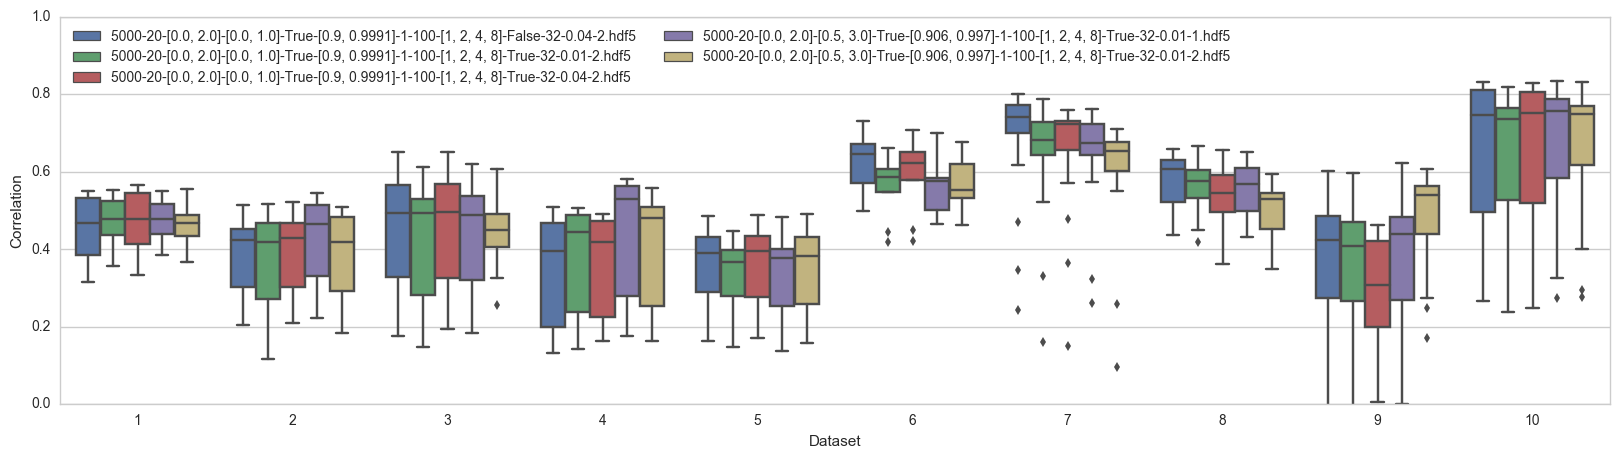

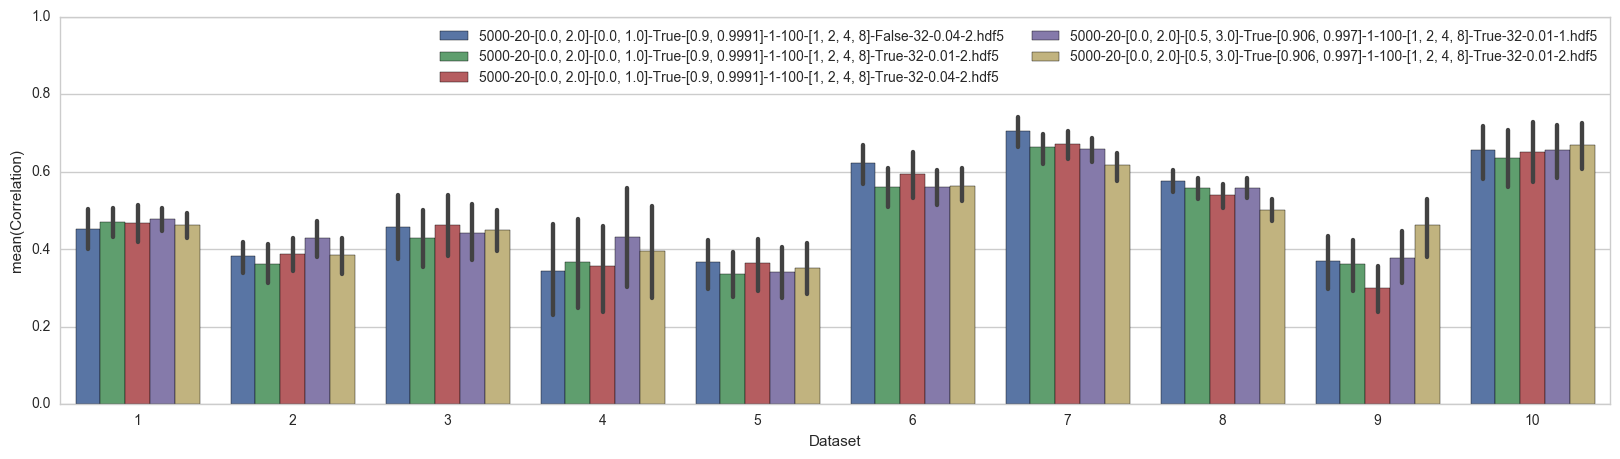

In [9]:
plt.figure(figsize=(16,3))
utils.plot_results(results_all)

plt.figure(figsize=(16,3))
utils.plot_results(results_all, kind='bar')

5000-20-[0.0, 2.0]-[0.0, 1.0]-True-[0.9, 0.9991]-1-100-[1, 2, 4, 8]-False-32-0.04-2.hdf5 0.62323764265 0.62323764265


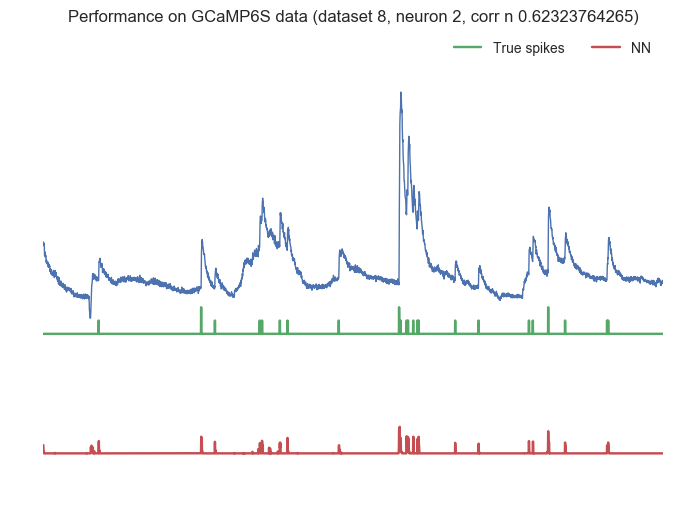

In [10]:
# Which dataset to plot
ds = 8

# Which neuron to plot
neuron = 2

# Plot train or test data
train = True

# Plot the best model for this dataset
model_idx = names.index(best_models[ds-1])

high = True if ds in high_ds else False
fixed = [0] if high_resolution is False else None

corr = utils.plot_inference(ds, models[model_idx], name=names[model_idx],
                            fixed=fixed, p=ar[model_idx],
                            covariates=covariates, high_resolution=high,
                            train=train, neuron_idx=2)

print(best_models[ds-1], np.mean(corr), np.median(corr))